In [1]:
from Gao_Algorithm import *
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from datafold.pcfold import PCManifold
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
import GPy
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
path ="C:/Users/anany/Desktop/master_thesis-master/DuckDuckGeese/DuckDuckGeese_TRAIN.arff"
soundlist = pd.DataFrame()
data, meta = arff.loadarff(path)
df = pd.DataFrame(data)

In [4]:
I, J, K = 50, 1345, 270
data = np.zeros((I, J * K))
for i in range(I):
    arr = np.zeros((J, K))
    for j in range(J):
        for k in range(K):
            arr[j][k] = df['relationalAtt'][i][j][k]
    arr = arr.reshape(1, -1)
    data[i] = arr
data = np.array(data)
data.shape

(50, 363150)

In [5]:
path ="C:/Users/anany/Desktop/master_thesis-master/DuckDuckGeese/DuckDuckGeese_TEST.arff"
soundlist_test = pd.DataFrame()
data_test, meta = arff.loadarff(path)
df_test = pd.DataFrame(data_test)

In [6]:
I, J, K = 50, 1345, 270
data_test = np.zeros((I, J * K))
for i in range(I):
    arr_test = np.zeros((J, K))
    for j in range(J):
        for k in range(K):
            arr_test[j][k] = df_test['relationalAtt'][i][j][k]
    arr_test = arr_test.reshape(1, -1)
    data_test[i] = arr_test
data_test = np.array(data_test)
data_test.shape

(50, 363150)

In [7]:
y_train = []

for i in range(50):
    y_train.append(df['target'][i])
y_test = []

for i in range(50):
    y_test.append(df_test['target'][i])

In [8]:
y = y_train + y_test
y = np.array(y)
y.shape

(100,)

In [9]:
y = y.reshape(y.shape[0], 1)

In [10]:
labels = {'Black-bellied_Whistling_Duck': 1,'Canadian_Goose': 2, 'Greylag_Goose': 3, 'Pink-footed_Goose': 4, 
          'White-faced_Whistling_Duck' : 5} 
y = [labels[item[0].decode('ascii')] for item in y]
y = np.array(y)
X = np.concatenate((data, data_test))

In [11]:
X.shape

(100, 363150)

In [12]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [13]:
n_classes = 5

print("Classes: ", np.unique(y))
print("Number of points per class:", [np.sum(y==k) for k in np.unique(y)])

random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

Classes:  [1 2 3 4 5]
Number of points per class: [20, 20, 20, 20, 20]


In [18]:
#####DIVIDING DATASETS INTO BATCHES ##### 

num_lmk_per_batch = 5 # how many landmarks to find per batch
batch_size = 10       # points per batch
n_batches = 2 # number of batches chosen per class

total_landmarks = np.array([])
idx_all = np.arange(X_train.shape[0])

# define a random number generator and use it to draw samples for batching
_rng = np.random.default_rng(random_state)
x = []
x_labels = []
for current_class in np.unique(y_train):
    
    # setup the dataset for the current class
    idx_class = (y_train == current_class)
    X_train_class = X_train[idx_class, :]
    y_train_class = y_train[idx_class]
    total_landmarks_class = np.array([])
    
    print(f"Number of points in class {current_class}: {X_train_class.shape[0]}")
    
    for _ in range(n_batches):
    
        # draw new batch at random
        batch_indices = _rng.choice(X_train_class.shape[0], size=(batch_size,))
        cat_data = X_train_class[batch_indices,:]
        x.append(cat_data)
        x_labels.append(y_train_class[batch_indices])
        # append the previous landmark data points to the array so that we can use them for the next landmarking call
        if len(total_landmarks_class) > 0:
            cat_data = np.row_stack([X_train_class[total_landmarks_class,:], cat_data])
        print(f"cat_data shape: {cat_data.shape[0]}")
        (GPLmkIdx, ptuq) = GetGPLmk_Euclidean(cat_data, num_lmk_per_batch, batch_size, BNN = 4, len(total_landmarks_class))
        # clean up the new indices by removing the ones we know
        GPLmkIdx = GPLmkIdx[len(total_landmarks_class):] - len(total_landmarks_class)
        GPLmkIdx = GPLmkIdx[GPLmkIdx >= 0]
        # add the new indices to the old ones
        unique_new_landmarks = np.unique(batch_indices[GPLmkIdx])
        total_landmarks_class = np.concatenate([total_landmarks_class, unique_new_landmarks]).astype(np.int)
    
    print(f"Found {len(total_landmarks_class)} landmarks for class {current_class}.")
    
    total_landmarks = np.concatenate([total_landmarks, idx_all[idx_class][total_landmarks_class]]).astype(np.int)
    
print(f"Total number of landmarks: {len(total_landmarks)}")
tot_landmarks = np.array(total_landmarks)
tot_landmarks = tot_landmarks.reshape(-1, )
x = np.array(x)
x = x.reshape(5 * n_batches * batch_size, -1)
x_labels = np.array(x_labels)
x_labels = x_labels.reshape(-1, )

Number of points in class 1: 17
cat_data shape: 10
cat_data shape: 12
Found 5 landmarks for class 1.
Number of points in class 2: 17
cat_data shape: 10
cat_data shape: 14
Found 6 landmarks for class 2.
Number of points in class 3: 15
cat_data shape: 10
cat_data shape: 12
Found 5 landmarks for class 3.
Number of points in class 4: 14
cat_data shape: 10
cat_data shape: 13
Found 4 landmarks for class 4.
Number of points in class 5: 17
cat_data shape: 10
cat_data shape: 12
Found 5 landmarks for class 5.
Total number of landmarks: 25


In [19]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(x_labels.reshape(-1, 1))
onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

In [20]:
number_of_classes = 5
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

In [21]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

In [22]:
def landmark_gp_clustering_accuracy(landmarks, landmark_labels, coords, y):
    if(landmarks.shape[0] < 2):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [24]:
np.random.shuffle(tot_landmarks)

In [25]:
accuracies_gp = [landmark_gp_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0,tot_landmarks.shape[0] , 1)]

Landmarks:  2 Accuracy:  0.15
Landmarks:  3 Accuracy:  0.3
Landmarks:  4 Accuracy:  0.3
Landmarks:  5 Accuracy:  0.3
Landmarks:  6 Accuracy:  0.15
Landmarks:  7 Accuracy:  0.15
Landmarks:  8 Accuracy:  0.15
Landmarks:  9 Accuracy:  0.15
Landmarks:  10 Accuracy:  0.15
Landmarks:  11 Accuracy:  0.15
Landmarks:  12 Accuracy:  0.15
Landmarks:  13 Accuracy:  0.15
Landmarks:  14 Accuracy:  0.15
Landmarks:  15 Accuracy:  0.15
Landmarks:  16 Accuracy:  0.15
Landmarks:  17 Accuracy:  0.15
Landmarks:  18 Accuracy:  0.15
Landmarks:  19 Accuracy:  0.15
Landmarks:  20 Accuracy:  0.15
Landmarks:  21 Accuracy:  0.15
Landmarks:  22 Accuracy:  0.15
Landmarks:  23 Accuracy:  0.15
Landmarks:  24 Accuracy:  0.15


In [26]:
def landmark_clustering_accuracy(landmarks, landmarks_labels, coords, y):
    if(landmarks.shape[0] < 2):
        return 0
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmarks_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [27]:
accuracies_knn = [landmark_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  2 Accuracy:  0.3
Landmarks:  3 Accuracy:  0.3
Landmarks:  4 Accuracy:  0.45
Landmarks:  5 Accuracy:  0.45
Landmarks:  6 Accuracy:  0.45
Landmarks:  7 Accuracy:  0.45
Landmarks:  8 Accuracy:  0.45
Landmarks:  9 Accuracy:  0.45
Landmarks:  10 Accuracy:  0.45
Landmarks:  11 Accuracy:  0.45
Landmarks:  12 Accuracy:  0.45
Landmarks:  13 Accuracy:  0.45
Landmarks:  14 Accuracy:  0.45
Landmarks:  15 Accuracy:  0.45
Landmarks:  16 Accuracy:  0.45
Landmarks:  17 Accuracy:  0.45
Landmarks:  18 Accuracy:  0.45
Landmarks:  19 Accuracy:  0.45
Landmarks:  20 Accuracy:  0.45
Landmarks:  21 Accuracy:  0.45
Landmarks:  22 Accuracy:  0.45
Landmarks:  23 Accuracy:  0.4
Landmarks:  24 Accuracy:  0.4


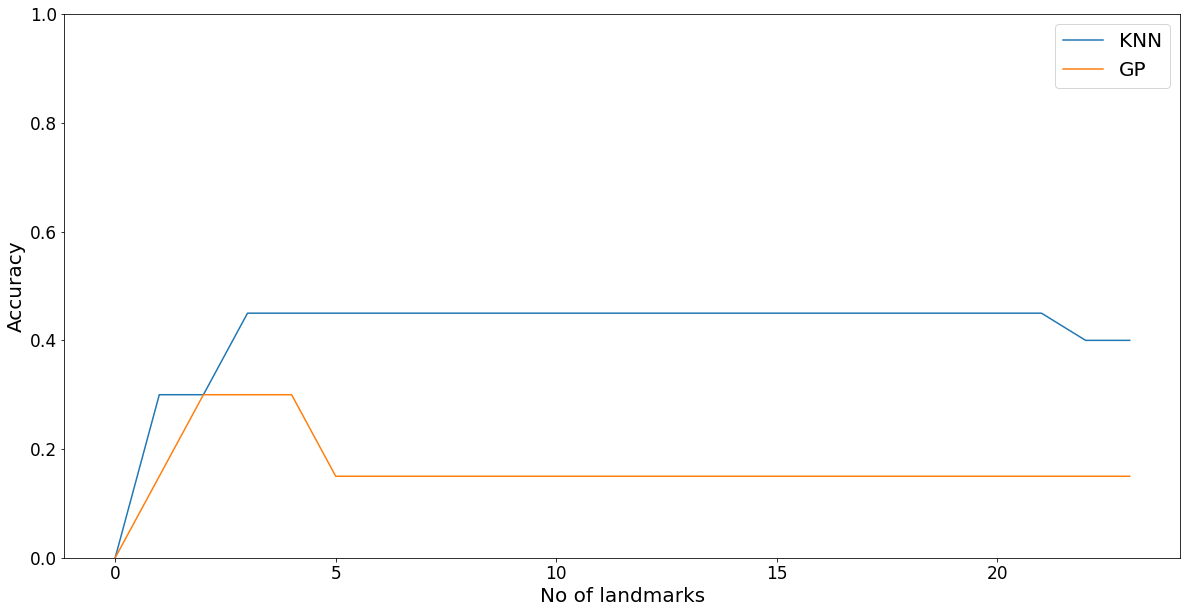

In [14]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, tot_landmarks.shape[0], 1), accuracies_knn, label = "KNN")
plt.plot(range(0, tot_landmarks.shape[0], 1), accuracies_gp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
#plt.title('Gao algorithm accuracies vs landmarks using KNN and GP' ,fontsize=16)
plt.legend(fontsize=20)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_gao_duckduckgeese.png')